In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette('cubehelix')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import pyfolio as pf

/opt/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [4]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

## Evaluating the performance of a basic 1/n portfolio

In [5]:
RISKY_ASSETS = ['AAPL', 'CBT', 'EQIX', 'GS', 'NFLX', 
                'PFE', 'SHEL', 'TSLA', 'UPS', 'WMT']
START_DATE = '2019-04-12'
END_DATE = '2019-05-26'

n_assets = len(RISKY_ASSETS)

[*********************100%***********************]  10 of 10 completed
Downloaded 30 rows of data.


<AxesSubplot:title={'center':'Stock prices of the considered assets'}, xlabel='Date'>

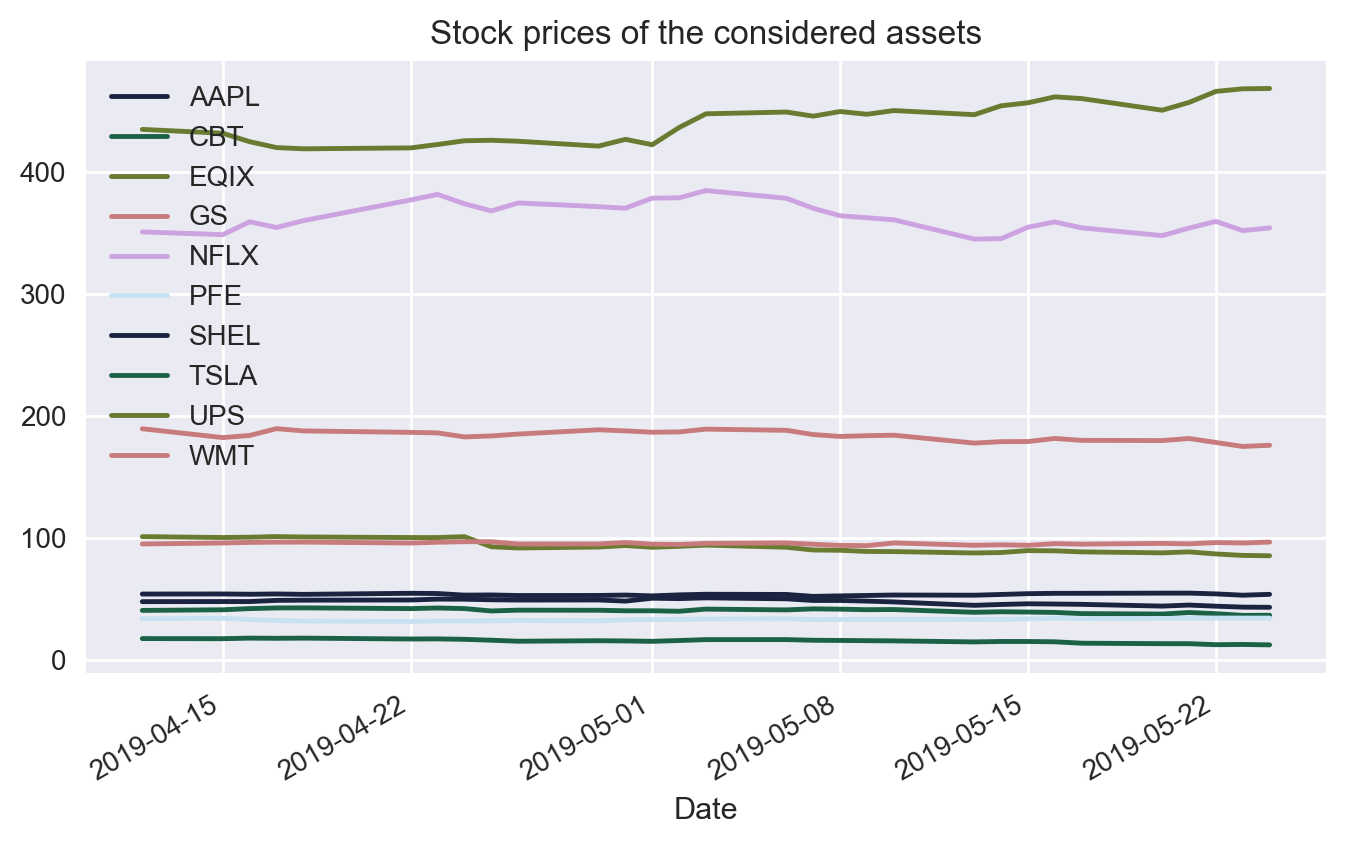

In [6]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, end=END_DATE)
print(f'Downloaded {prices_df.shape[0]} rows of data.')
prices_df['Adj Close'].plot(title='Stock prices of the considered assets')

In [7]:
returns = prices_df['Adj Close'].pct_change().dropna()

In [8]:
portfolio_weights = n_assets * [1/n_assets]

In [9]:
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T), index=returns.index)

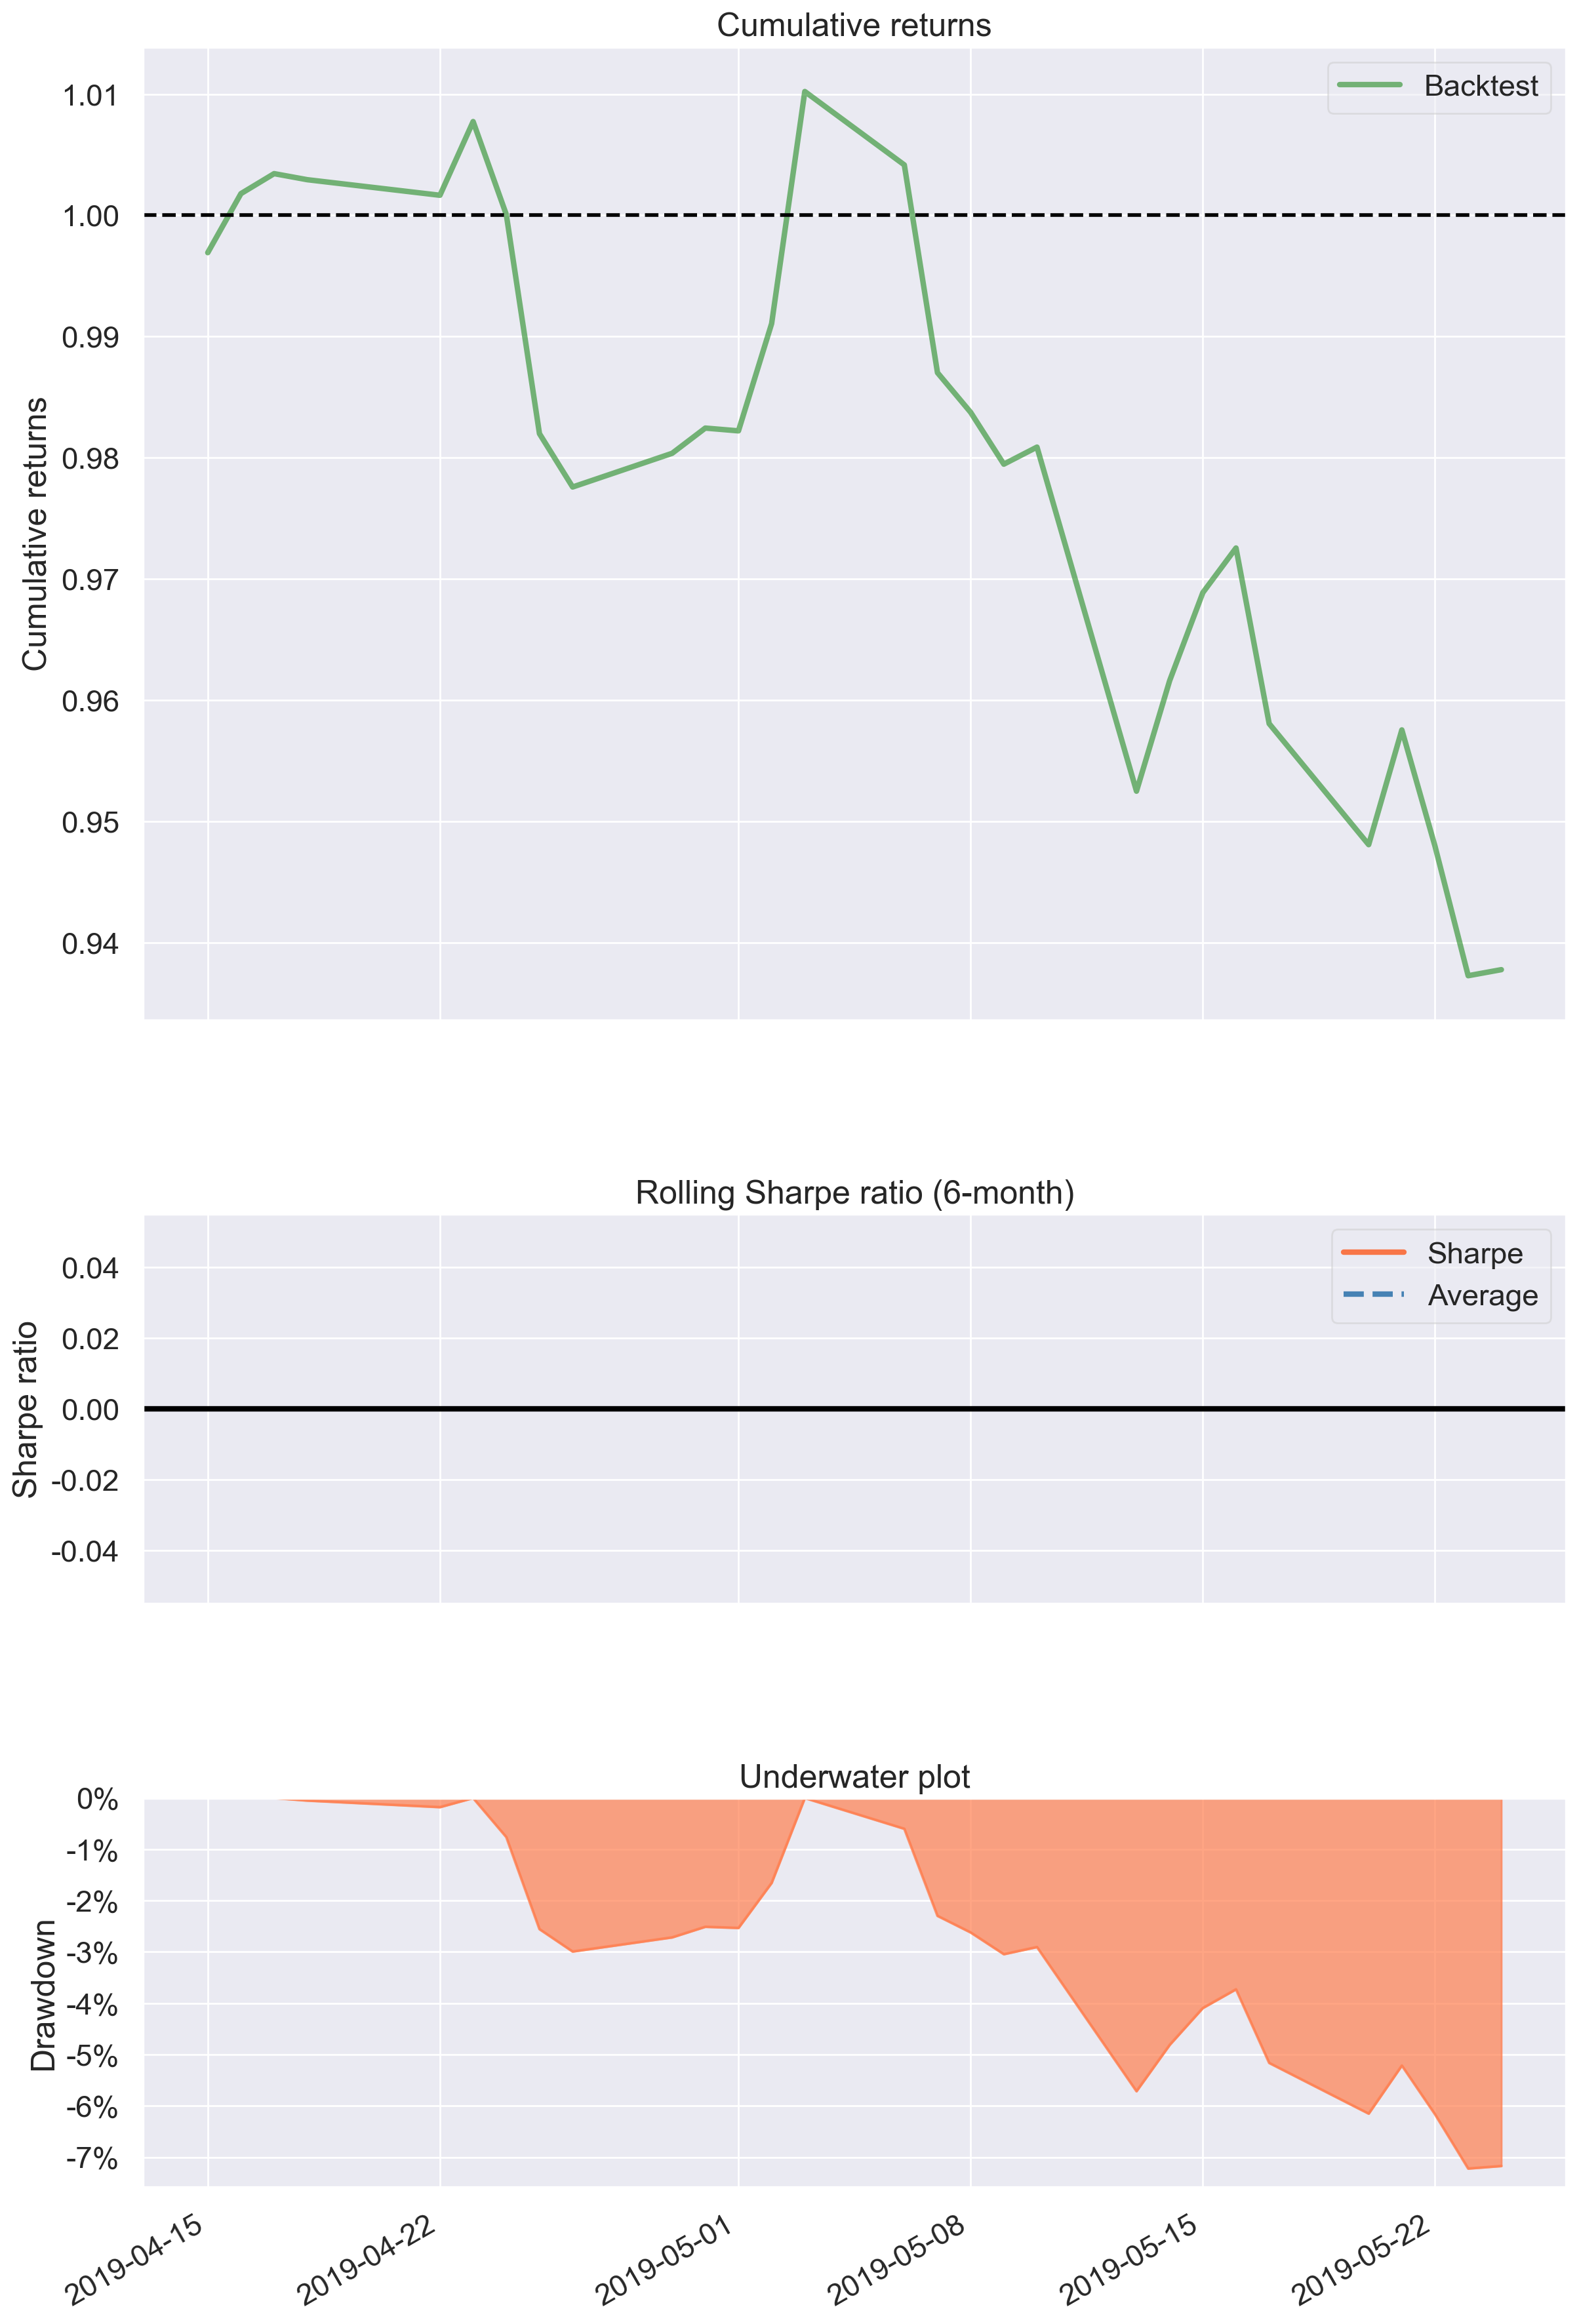

In [10]:
pf.create_simple_tear_sheet(portfolio_returns)

In [11]:
# pf.create_returns_tear_sheet(portfolio_returns)

## Finding the Efficient Frontier using Monte Carlo simulations

### average return

In [12]:
N_PORTFOLIOS = 10 ** 6
N_DAYS = 252
RISKY_ASSETS = ['TSLA', 'AAPL', 'CBT', 'EQIX', 'GS', 
                'NFLX', 'PFE', 'SHEL', 'UPS', 'WMT']
RISKY_ASSETS.sort()
START_DATE = '2019-01-01'
END_DATE = '2019-05-25'

n_assets = len(RISKY_ASSETS)

In [13]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  10 of 10 completed
Downloaded 100 rows of data.


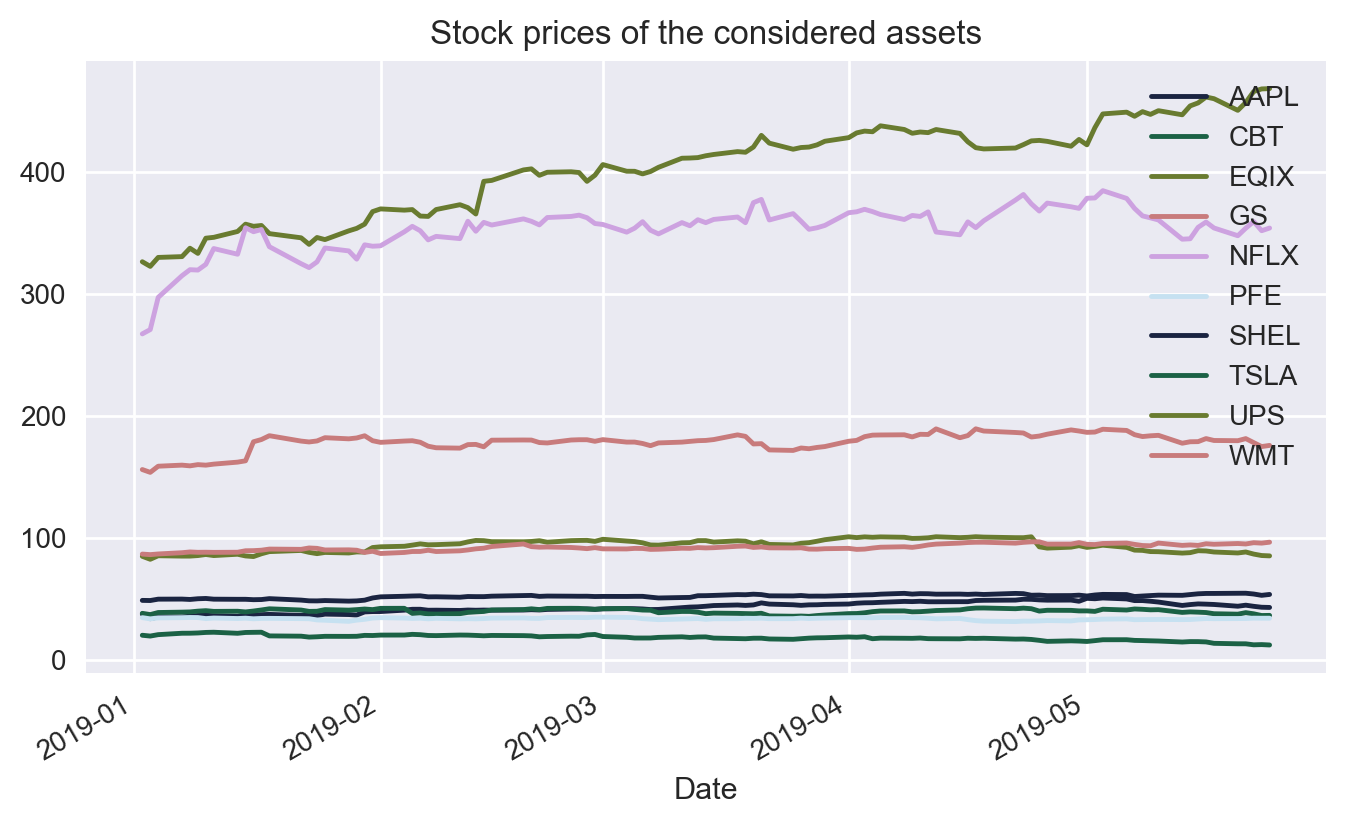

In [14]:
prices_df['Adj Close'].plot(title='Stock prices of the considered assets');

In [15]:
returns_df = prices_df['Adj Close'].pct_change().dropna()
avg_returns = returns_df.mean() * N_DAYS
avg_cov_mat = returns_df.cov() * N_DAYS

In [16]:
avg_returns

AAPL    0.387974
CBT    -0.052770
EQIX    0.942787
GS      0.335645
NFLX    0.781135
PFE    -0.014190
SHEL    0.253508
TSLA   -1.114817
UPS     0.039419
WMT     0.280132
dtype: float64

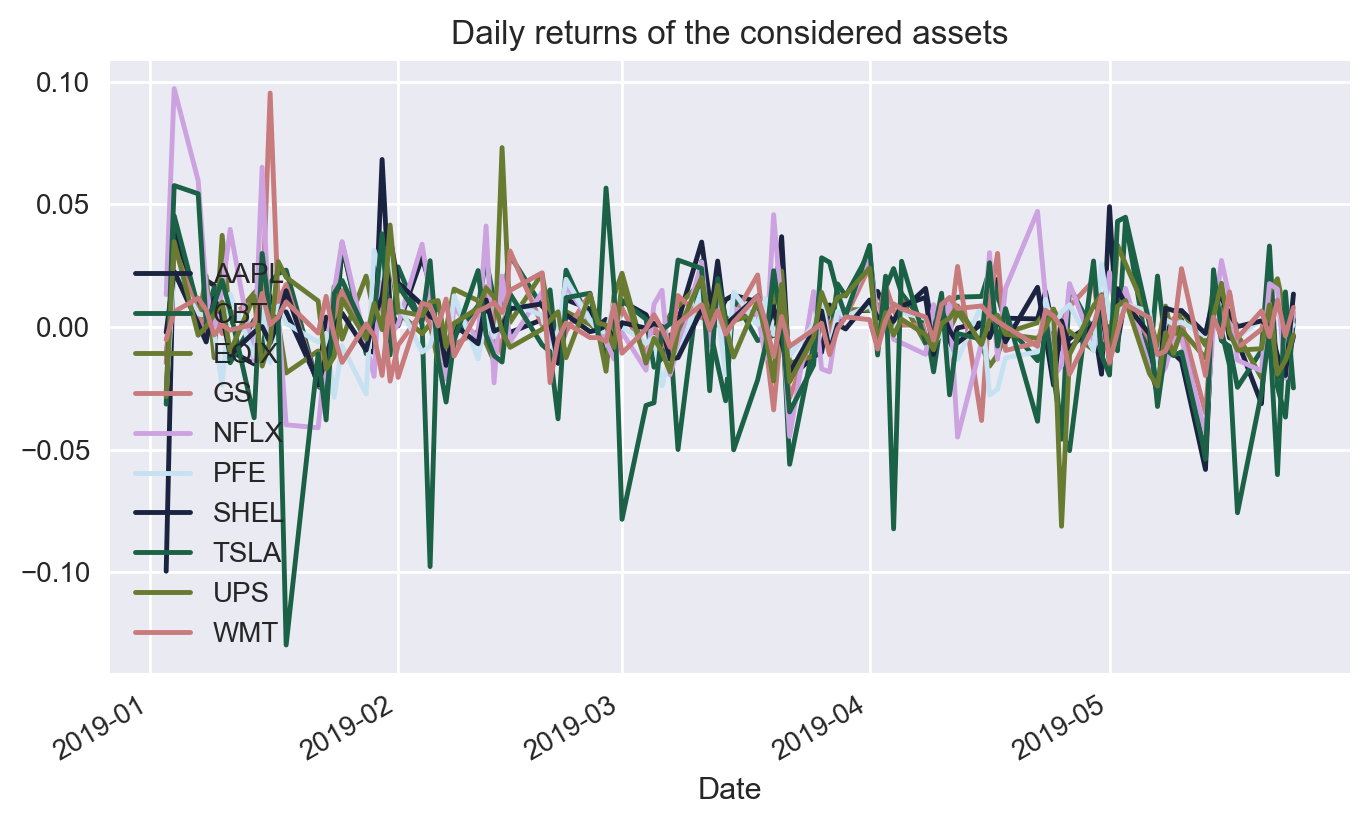

In [17]:
returns_df.plot(title='Daily returns of the considered assets');

In [18]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [19]:
portf_avg_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(avg_cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_avg_rtns / portf_vol

In [20]:
portf_results_avg_df = pd.DataFrame({'returns': portf_avg_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [21]:
N_POINTS = 200
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_avg_df.returns.min(), 
                            portf_results_avg_df.returns.max(), 
                            N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_avg_rtns = np.round(portf_avg_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_avg_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_avg_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

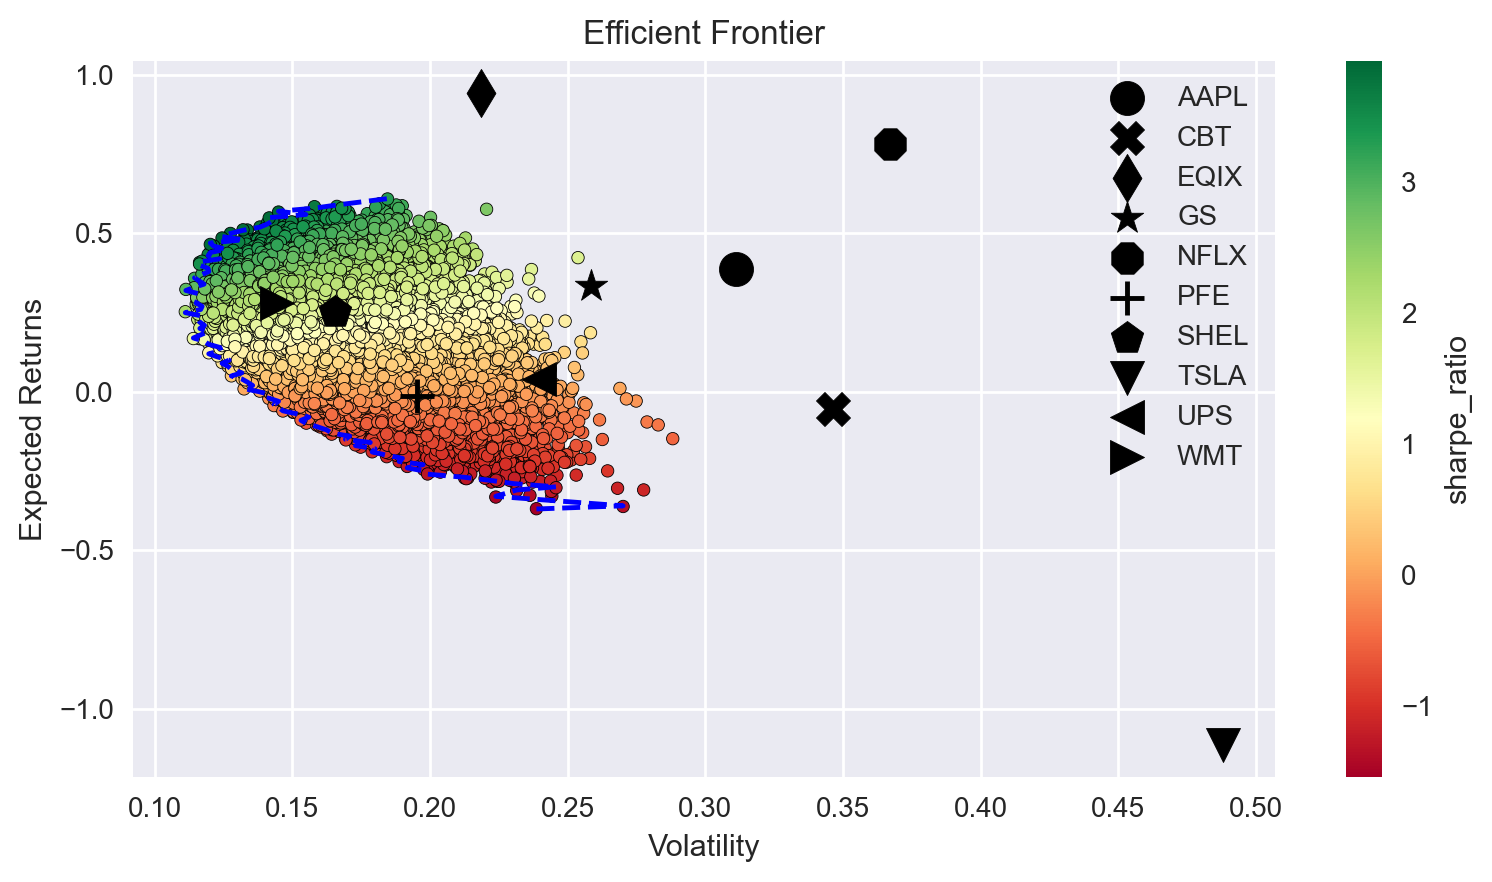

In [22]:
MARKS = ['o', 'X', 'd', '*', '8', '+', 'p', 'v', '<', '>']

fig, ax = plt.subplots()
portf_results_avg_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(avg_cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=RISKY_ASSETS[asset_index])
ax.legend()

plt.tight_layout()
#plt.savefig('images/ch7_im8.png')
plt.show()

In [23]:
max_sharpe_avg_ind = np.argmax(portf_results_avg_df.sharpe_ratio)
max_sharpe_avg_portf = portf_results_avg_df.loc[max_sharpe_avg_ind]

min_vol_avg_ind = np.argmin(portf_results_avg_df.volatility)
min_vol_avg_portf = portf_results_avg_df.loc[min_vol_avg_ind]

In [24]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_avg_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_avg_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 50.01% volatility: 12.75% sharpe_ratio: 392.27% 
Weights
AAPL: 0.71% CBT: 1.82% EQIX: 34.55% GS: 18.92% NFLX: 5.74% PFE: 6.85% SHEL: 2.44% TSLA: 1.16% UPS: 2.46% WMT: 25.35% 

In [25]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_avg_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_avg_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: 25.30% volatility: 11.11% sharpe_ratio: 227.70% 
Weights
AAPL: 0.06% CBT: 0.80% EQIX: 11.38% GS: 10.40% NFLX: 0.54% PFE: 10.53% SHEL: 18.70% TSLA: 4.14% UPS: 6.15% WMT: 37.30% 

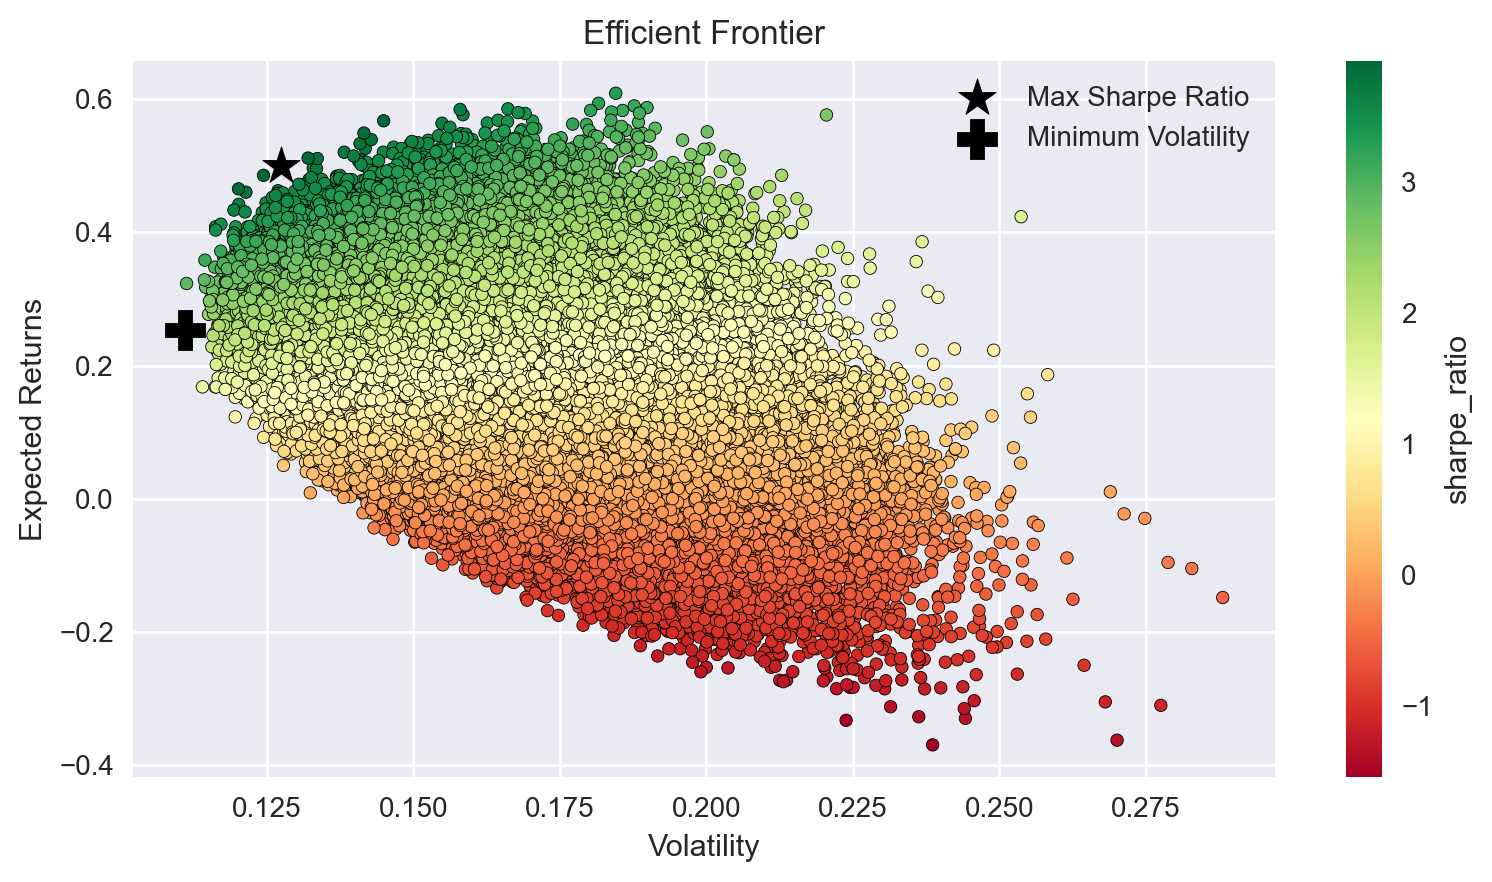

In [26]:
fig, ax = plt.subplots()
portf_results_avg_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_avg_portf.volatility, 
           y=max_sharpe_avg_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_avg_portf.volatility, 
           y=min_vol_avg_portf.returns, 
           c='black', marker='P', 
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
#plt.savefig('images/ch7_im11.png')
plt.show()

### SVR

In [27]:
N_PORTFOLIOS = 10 ** 6
N_DAYS = 252
RISKY_ASSETS = ['TSLA', 'AAPL', 'CBT', 'EQIX', 'GS', 
                'NFLX', 'PFE', 'SHEL', 'UPS', 'WMT']
RISKY_ASSETS.sort()
START_DATE = '2019-01-01'
END_DATE = '2019-04-12'

n_assets = len(RISKY_ASSETS)

In [28]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  10 of 10 completed
Downloaded 70 rows of data.


In [29]:
returns_df = prices_df['Adj Close'].pct_change().dropna()
svr_cov_mat = returns_df.cov() * N_DAYS
rtn_dic = {'AAPL':-0.002493806869369129, 'CBT':-0.002999445576705385, 'EQIX':0.0029356391083643295, 
           'GS':-0.0015651083274184532,'NFLX':0.0007131372724711954, 'PFE':0.00009355433458318331, 
           'SHEL':-0.00002045511772380999, 'TSLA':-0.01080781237897565, 'UPS':-0.004613518225355425, 
           'WMT':0.0013656977850442372}
svr_returns = pd.Series(rtn_dic) * N_DAYS

In [30]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [31]:
portf_svr_rtns = np.dot(weights, svr_returns)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(svr_cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_svr_rtns / portf_vol

In [32]:
portf_results_svr_df = pd.DataFrame({'returns': portf_svr_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [33]:
N_POINTS = 200
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_svr_df.returns.min(), 
                            portf_results_svr_df.returns.max(), 
                            N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_svr_rtns = np.round(portf_svr_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_svr_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_svr_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

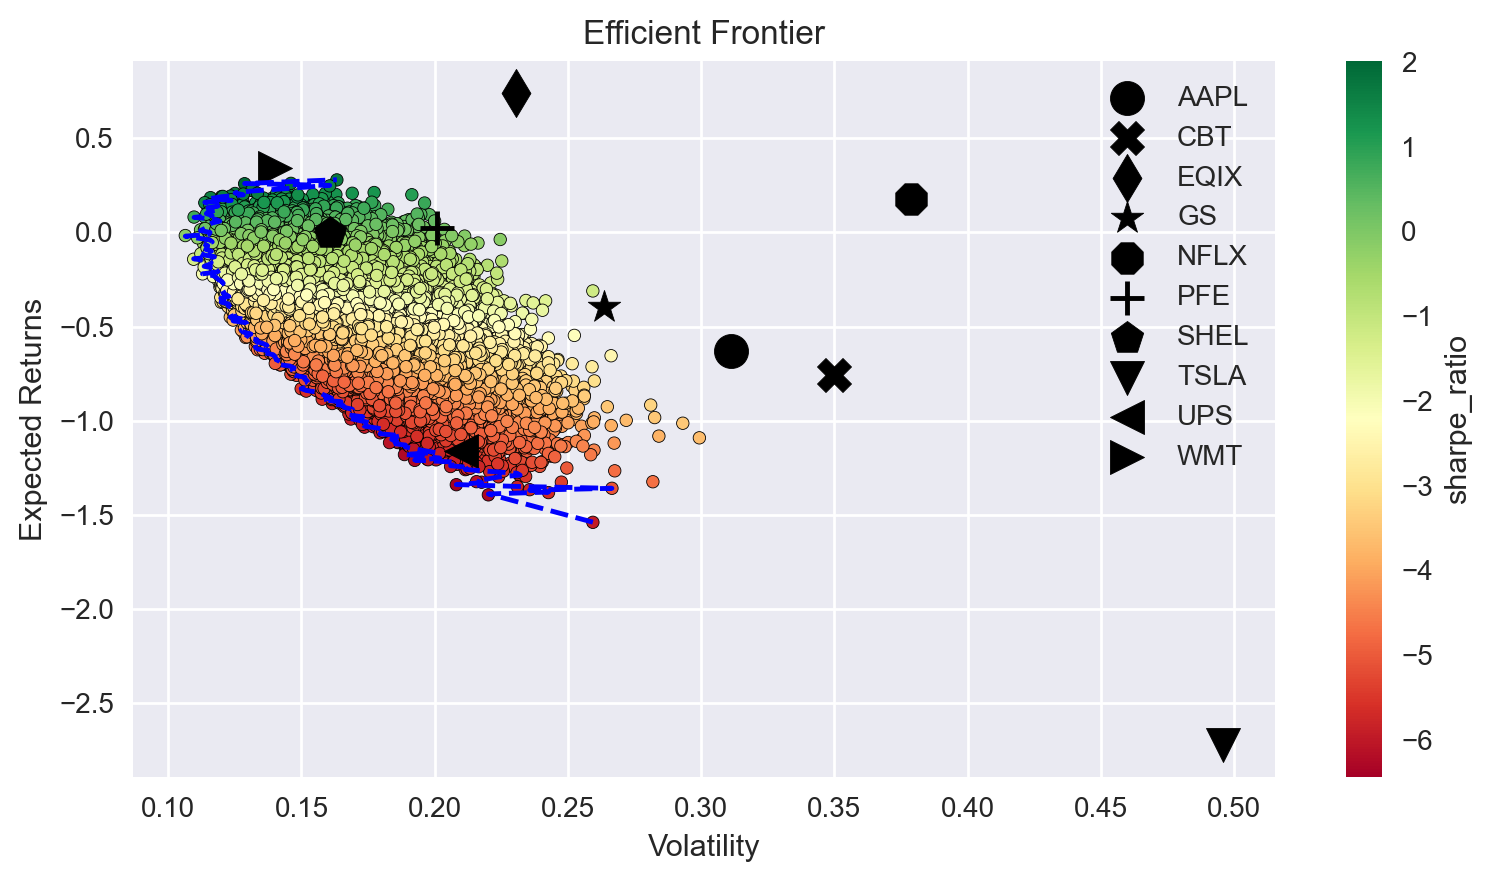

In [34]:
MARKS = ['o', 'X', 'd', '*', '8', '+', 'p', 'v', '<', '>']

fig, ax = plt.subplots()
portf_results_svr_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(svr_cov_mat.iloc[asset_index, asset_index]), 
                y=svr_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=RISKY_ASSETS[asset_index])
ax.legend()

plt.tight_layout()
#plt.savefig('images/ch7_im8.png')
plt.show()

In [35]:
max_sharpe_svr_ind = np.argmax(portf_results_svr_df.sharpe_ratio)
max_sharpe_svr_portf = portf_results_svr_df.loc[max_sharpe_svr_ind]

min_vol_svr_ind = np.argmin(portf_results_svr_df.volatility)
min_vol_svr_portf = portf_results_svr_df.loc[min_vol_svr_ind]

In [36]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_svr_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_svr_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 25.89% volatility: 12.87% sharpe_ratio: 201.26% 
Weights
AAPL: 0.60% CBT: 5.72% EQIX: 29.61% GS: 4.75% NFLX: 10.23% PFE: 12.13% SHEL: 2.05% TSLA: 0.81% UPS: 0.71% WMT: 33.38% 

In [37]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_svr_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_svr_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: -1.66% volatility: 10.64% sharpe_ratio: -15.59% 
Weights
AAPL: 0.06% CBT: 0.80% EQIX: 11.38% GS: 10.40% NFLX: 0.54% PFE: 10.53% SHEL: 18.70% TSLA: 4.14% UPS: 6.15% WMT: 37.30% 

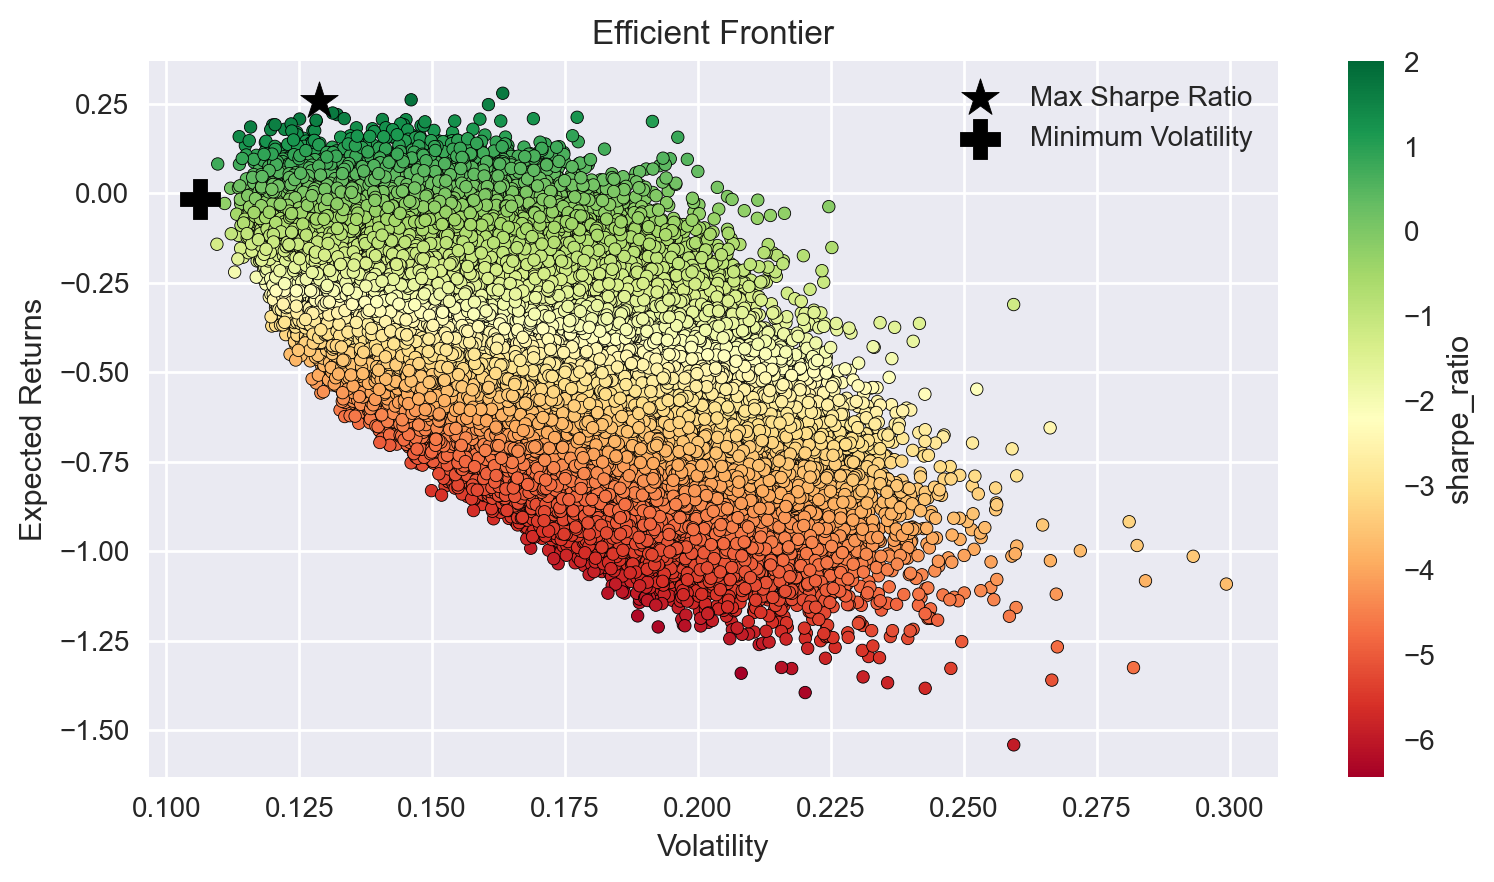

In [38]:
fig, ax = plt.subplots()
portf_results_svr_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_svr_portf.volatility, 
           y=max_sharpe_svr_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_svr_portf.volatility, 
           y=min_vol_svr_portf.returns, 
           c='black', marker='P', 
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
#plt.savefig('images/ch7_im11.png')
plt.show()

### LSTM+COV shrinkage

In [39]:
N_PORTFOLIOS = 10 ** 6
N_DAYS = 252
RISKY_ASSETS = ['TSLA', 'AAPL', 'CBT', 'EQIX', 'GS', 
                'NFLX', 'PFE', 'SHEL', 'UPS', 'WMT']
RISKY_ASSETS.sort()
START_DATE = '2019-01-01'
END_DATE = '2019-04-12'

n_assets = len(RISKY_ASSETS)

In [40]:
rtn_dic = {'AAPL': -0.03298, 'CBT': -0.003562, 'EQIX': 0.002803, 'GS': -0.002731, 'NFLX': 0.000561, 
          'PFE': 0.000562, 'SHEL': -0.000588, 'TSLA': -0.010810, 'UPS': -0.005699, 'WMT': 0.000354}
lstm_returns = pd.Series(rtn_dic) * N_DAYS
lstm_cov_mat = pd.read_excel('./cov_shrinkage_result.xlsx', index_col=0)
lstm_cov_mat = lstm_cov_mat* N_DAYS

In [41]:
#lstm_cov_mat

In [42]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [43]:
portf_lstm_rtns = np.dot(weights, lstm_returns)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(lstm_cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_lstm_rtns / portf_vol

In [44]:
portf_results_lstm_df = pd.DataFrame({'returns': portf_lstm_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [45]:
N_POINTS = 200
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_lstm_df.returns.min(), 
                            portf_results_lstm_df.returns.max(), 
                            N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_lstm_rtns = np.round(portf_lstm_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_lstm_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_lstm_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

/var/folders/rh/qy0ycqz940j3swc5pycbcfh00000gn/T/ipykernel_30586/757581207.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


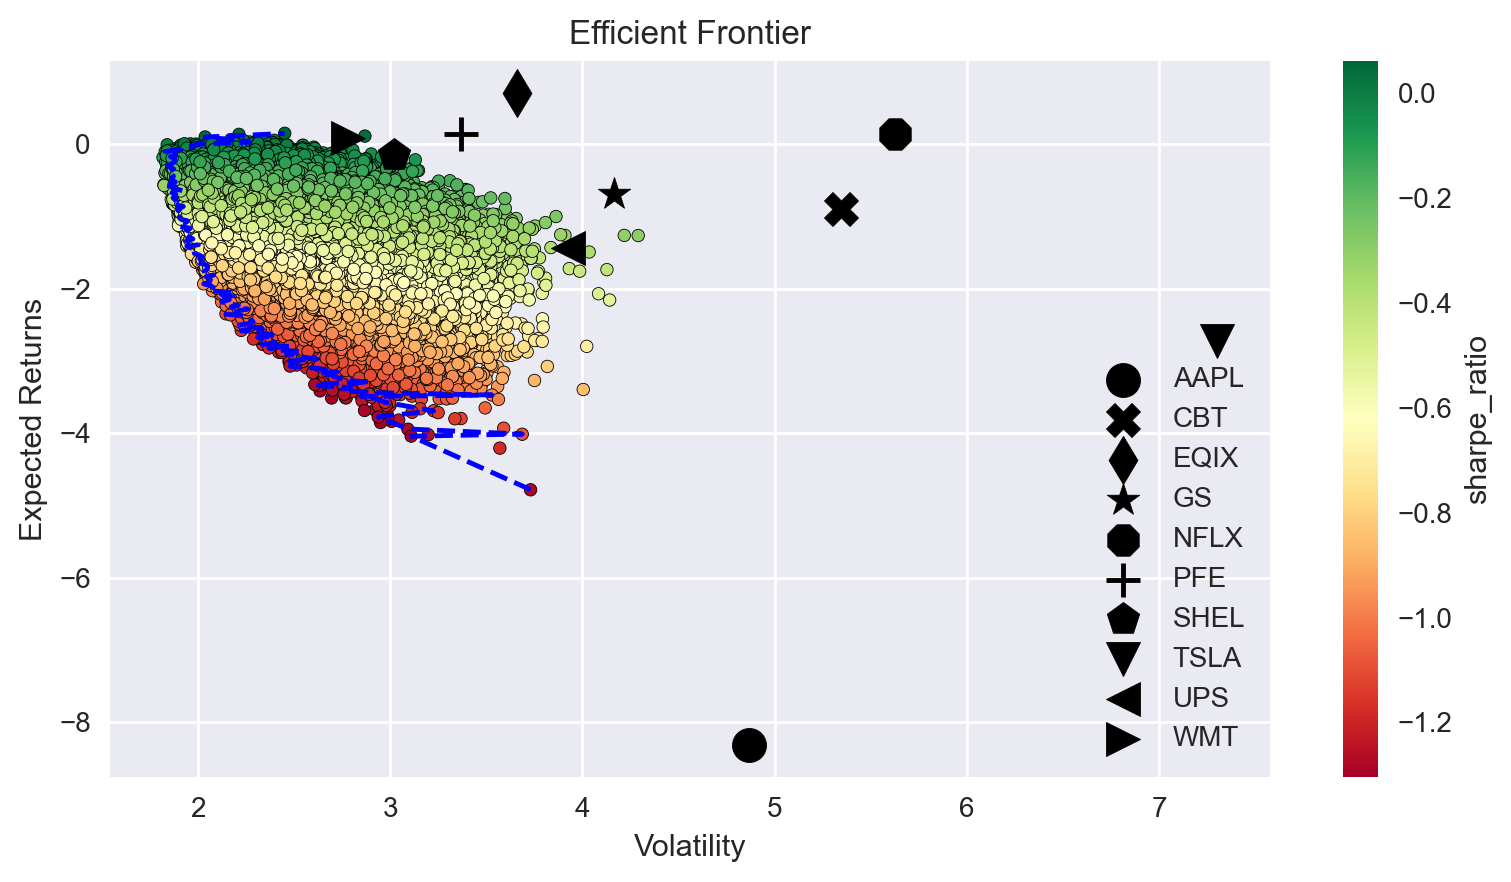

In [46]:
MARKS = ['o', 'X', 'd', '*', '8', '+', 'p', 'v', '<', '>']

fig, ax = plt.subplots()
portf_results_lstm_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(lstm_cov_mat.iloc[asset_index, asset_index]), 
                y=lstm_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=RISKY_ASSETS[asset_index])
ax.legend()

plt.tight_layout()
#plt.savefig('images/ch7_im8.png')
plt.show()

In [47]:
max_sharpe_lstm_ind = np.argmax(portf_results_lstm_df.sharpe_ratio)
max_sharpe_lstm_portf = portf_results_lstm_df.loc[max_sharpe_lstm_ind]

min_vol_lstm_ind = np.argmin(portf_results_lstm_df.volatility)
min_vol_lstm_portf = portf_results_lstm_df.loc[min_vol_lstm_ind]

In [48]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_lstm_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_lstm_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 13.77% volatility: 221.41% sharpe_ratio: 6.22% 
Weights
AAPL: 0.40% CBT: 1.42% EQIX: 26.08% GS: 1.80% NFLX: 21.13% PFE: 12.55% SHEL: 8.77% TSLA: 0.35% UPS: 2.47% WMT: 25.02% 

In [49]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_lstm_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_lstm_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: -18.30% volatility: 181.94% sharpe_ratio: -10.06% 
Weights
AAPL: 0.06% CBT: 0.80% EQIX: 11.38% GS: 10.40% NFLX: 0.54% PFE: 10.53% SHEL: 18.70% TSLA: 4.14% UPS: 6.15% WMT: 37.30% 

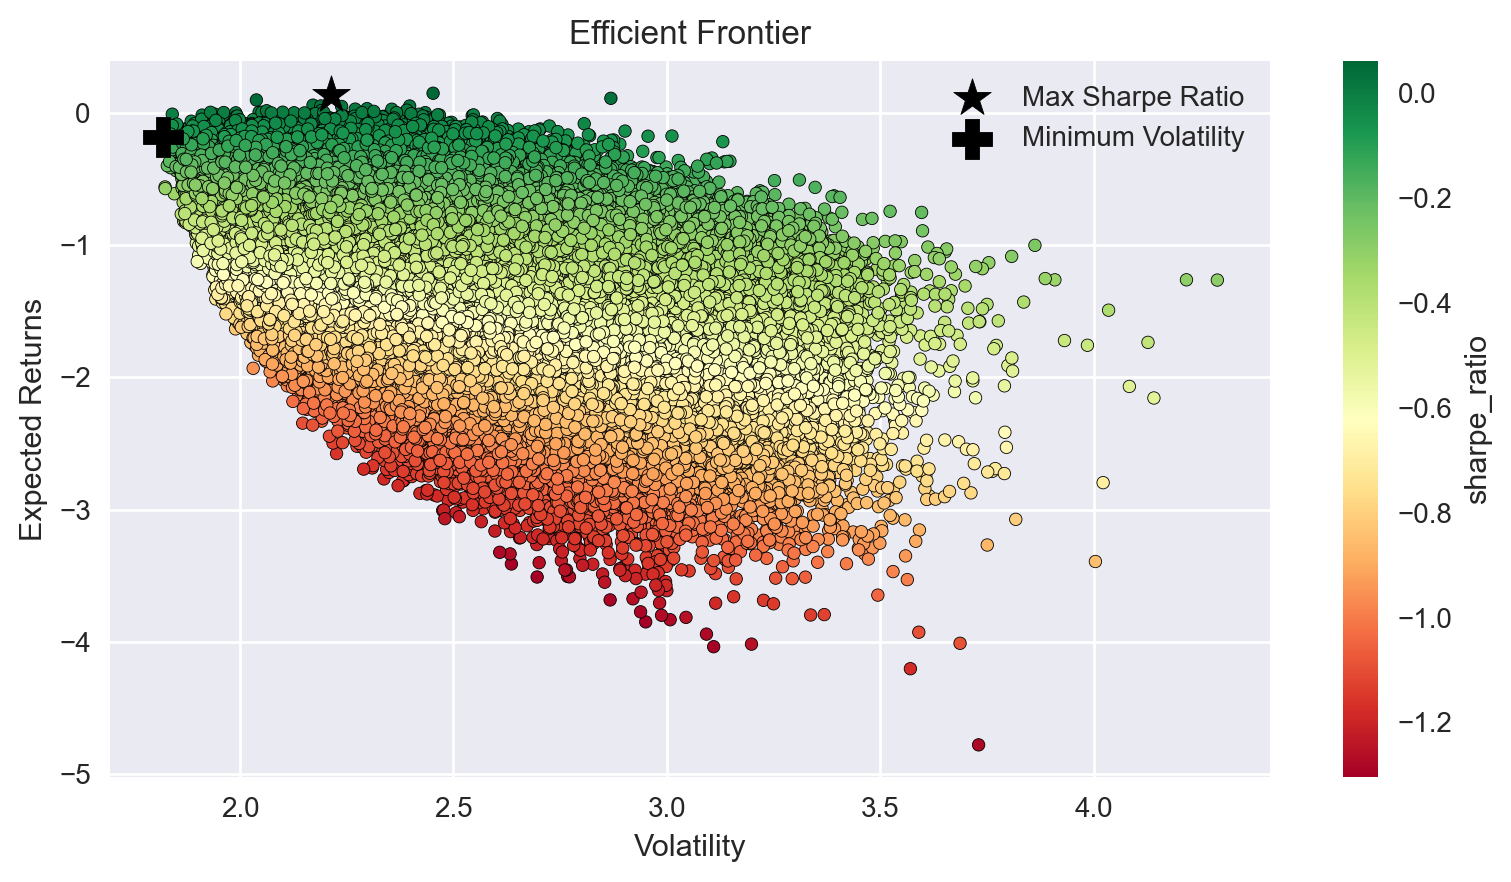

In [50]:
fig, ax = plt.subplots()
portf_results_lstm_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_lstm_portf.volatility, 
           y=max_sharpe_lstm_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_lstm_portf.volatility, 
           y=min_vol_lstm_portf.returns, 
           c='black', marker='P', 
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
#plt.savefig('images/ch7_im11.png')
plt.show()

## Evaluation the performance of our methods

In [51]:
RISKY_ASSETS = ['TSLA', 'AAPL', 'CBT', 'EQIX', 'GS', 
                'NFLX', 'PFE', 'SHEL', 'UPS', 'WMT']
RISKY_ASSETS.sort()
START_DATE = '2019-04-12'
END_DATE = '2019-05-25'

n_assets = len(RISKY_ASSETS)

In [52]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  10 of 10 completed
Downloaded 30 rows of data.


### 1/n method

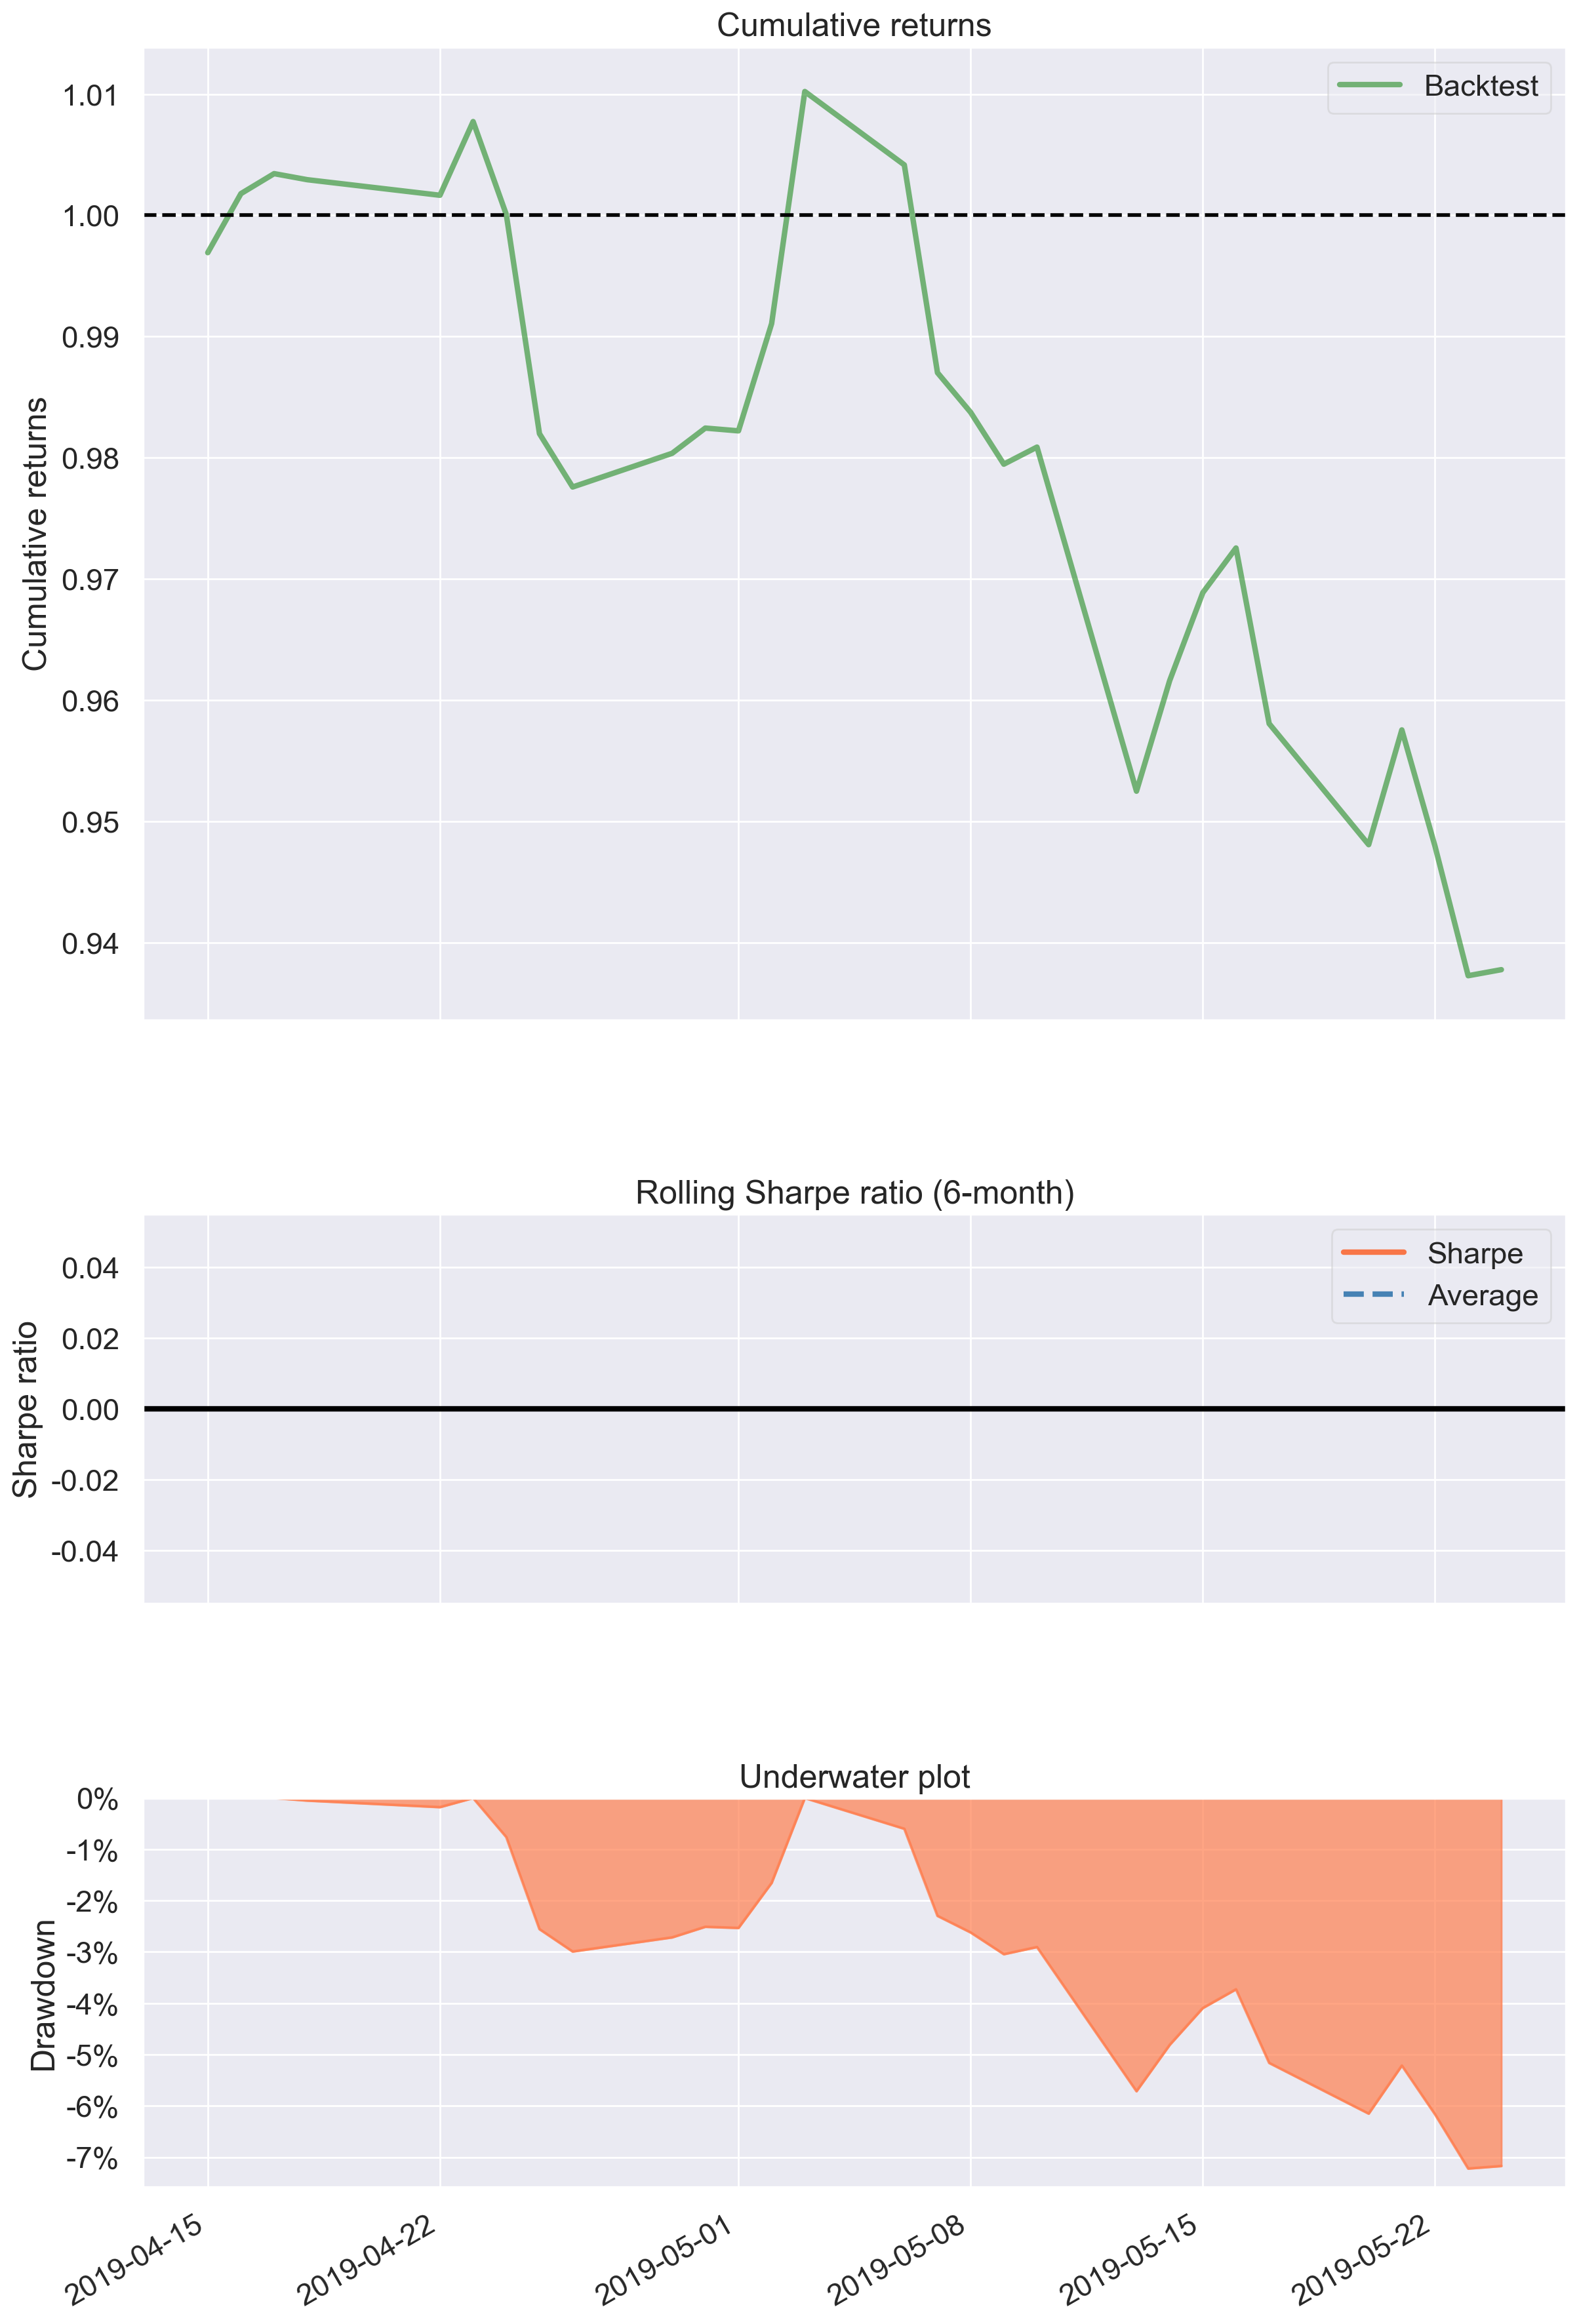

In [53]:
portfolio_weights = n_assets * [1/n_assets]
portfolio_weights
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T), index=returns.index)
pf.create_simple_tear_sheet(portfolio_returns)
#pf.create_returns_tear_sheet(portfolio_returns)

### average method

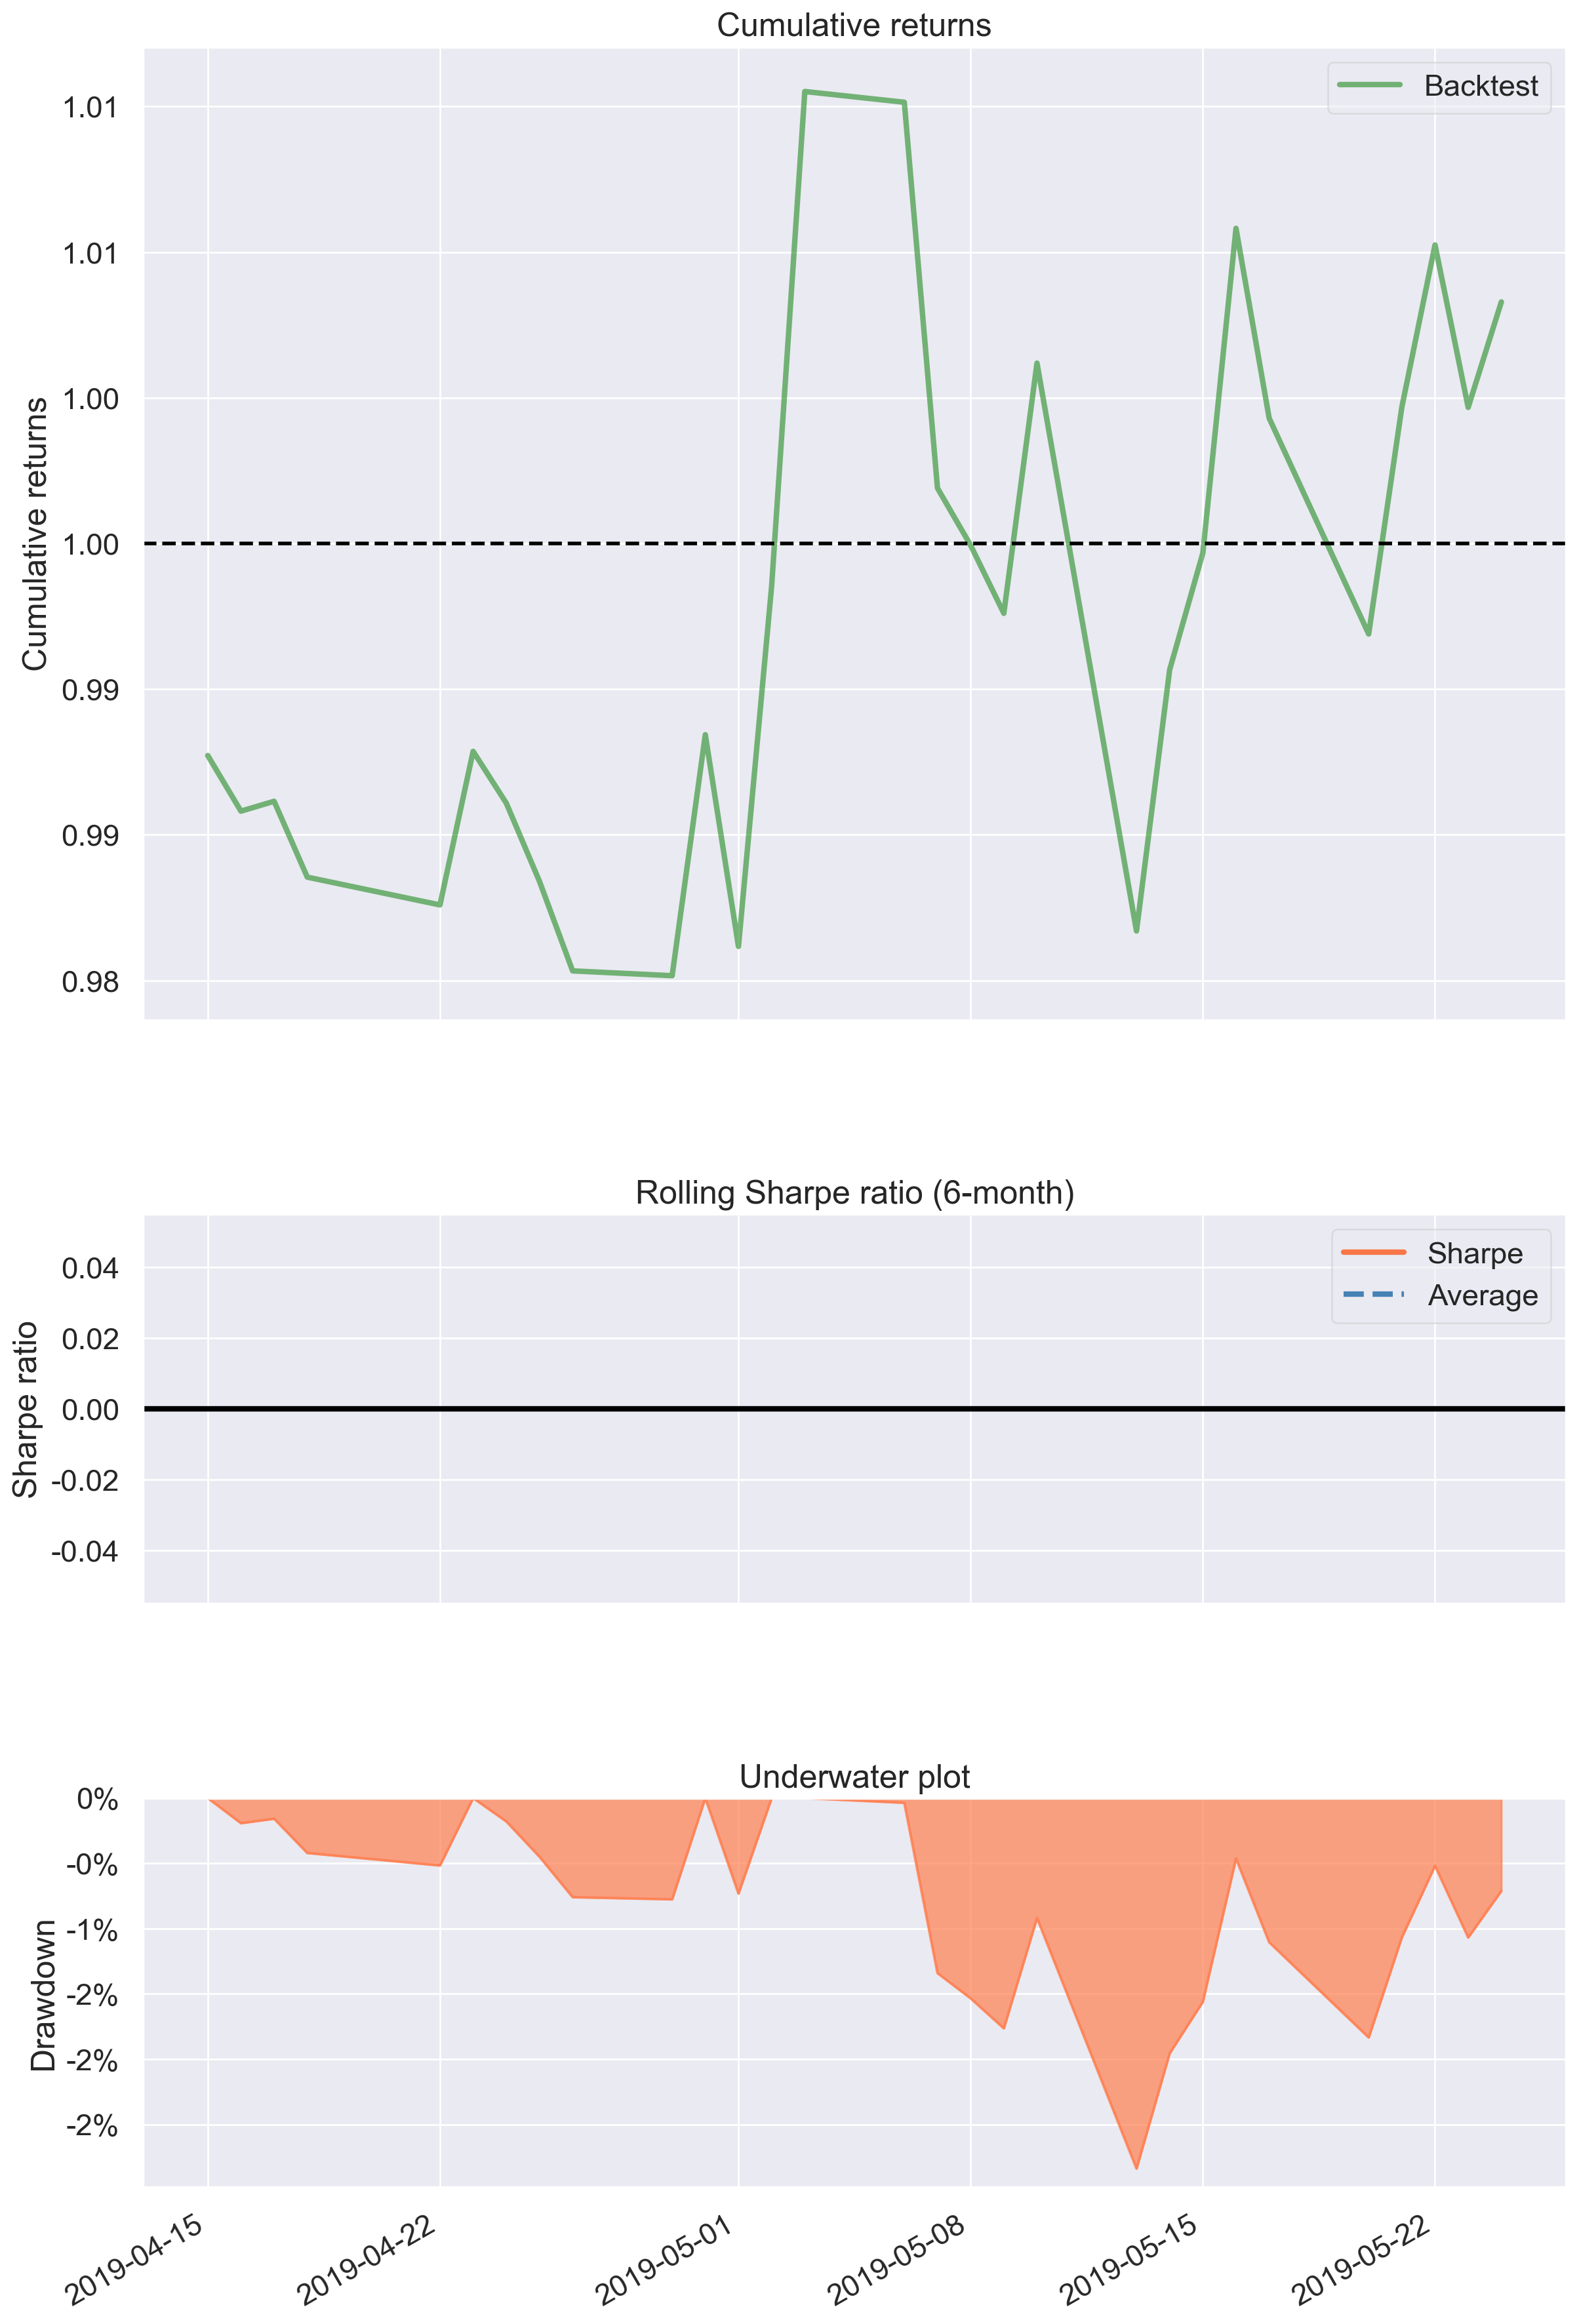

In [54]:
portfolio_weights = []
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_avg_df.sharpe_ratio)]):
    portfolio_weights.append(y)
returns = prices_df['Adj Close'].pct_change().dropna()
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T), index=returns.index)
pf.create_simple_tear_sheet(portfolio_returns)
#pf.create_returns_tear_sheet(portfolio_returns)

### SVR

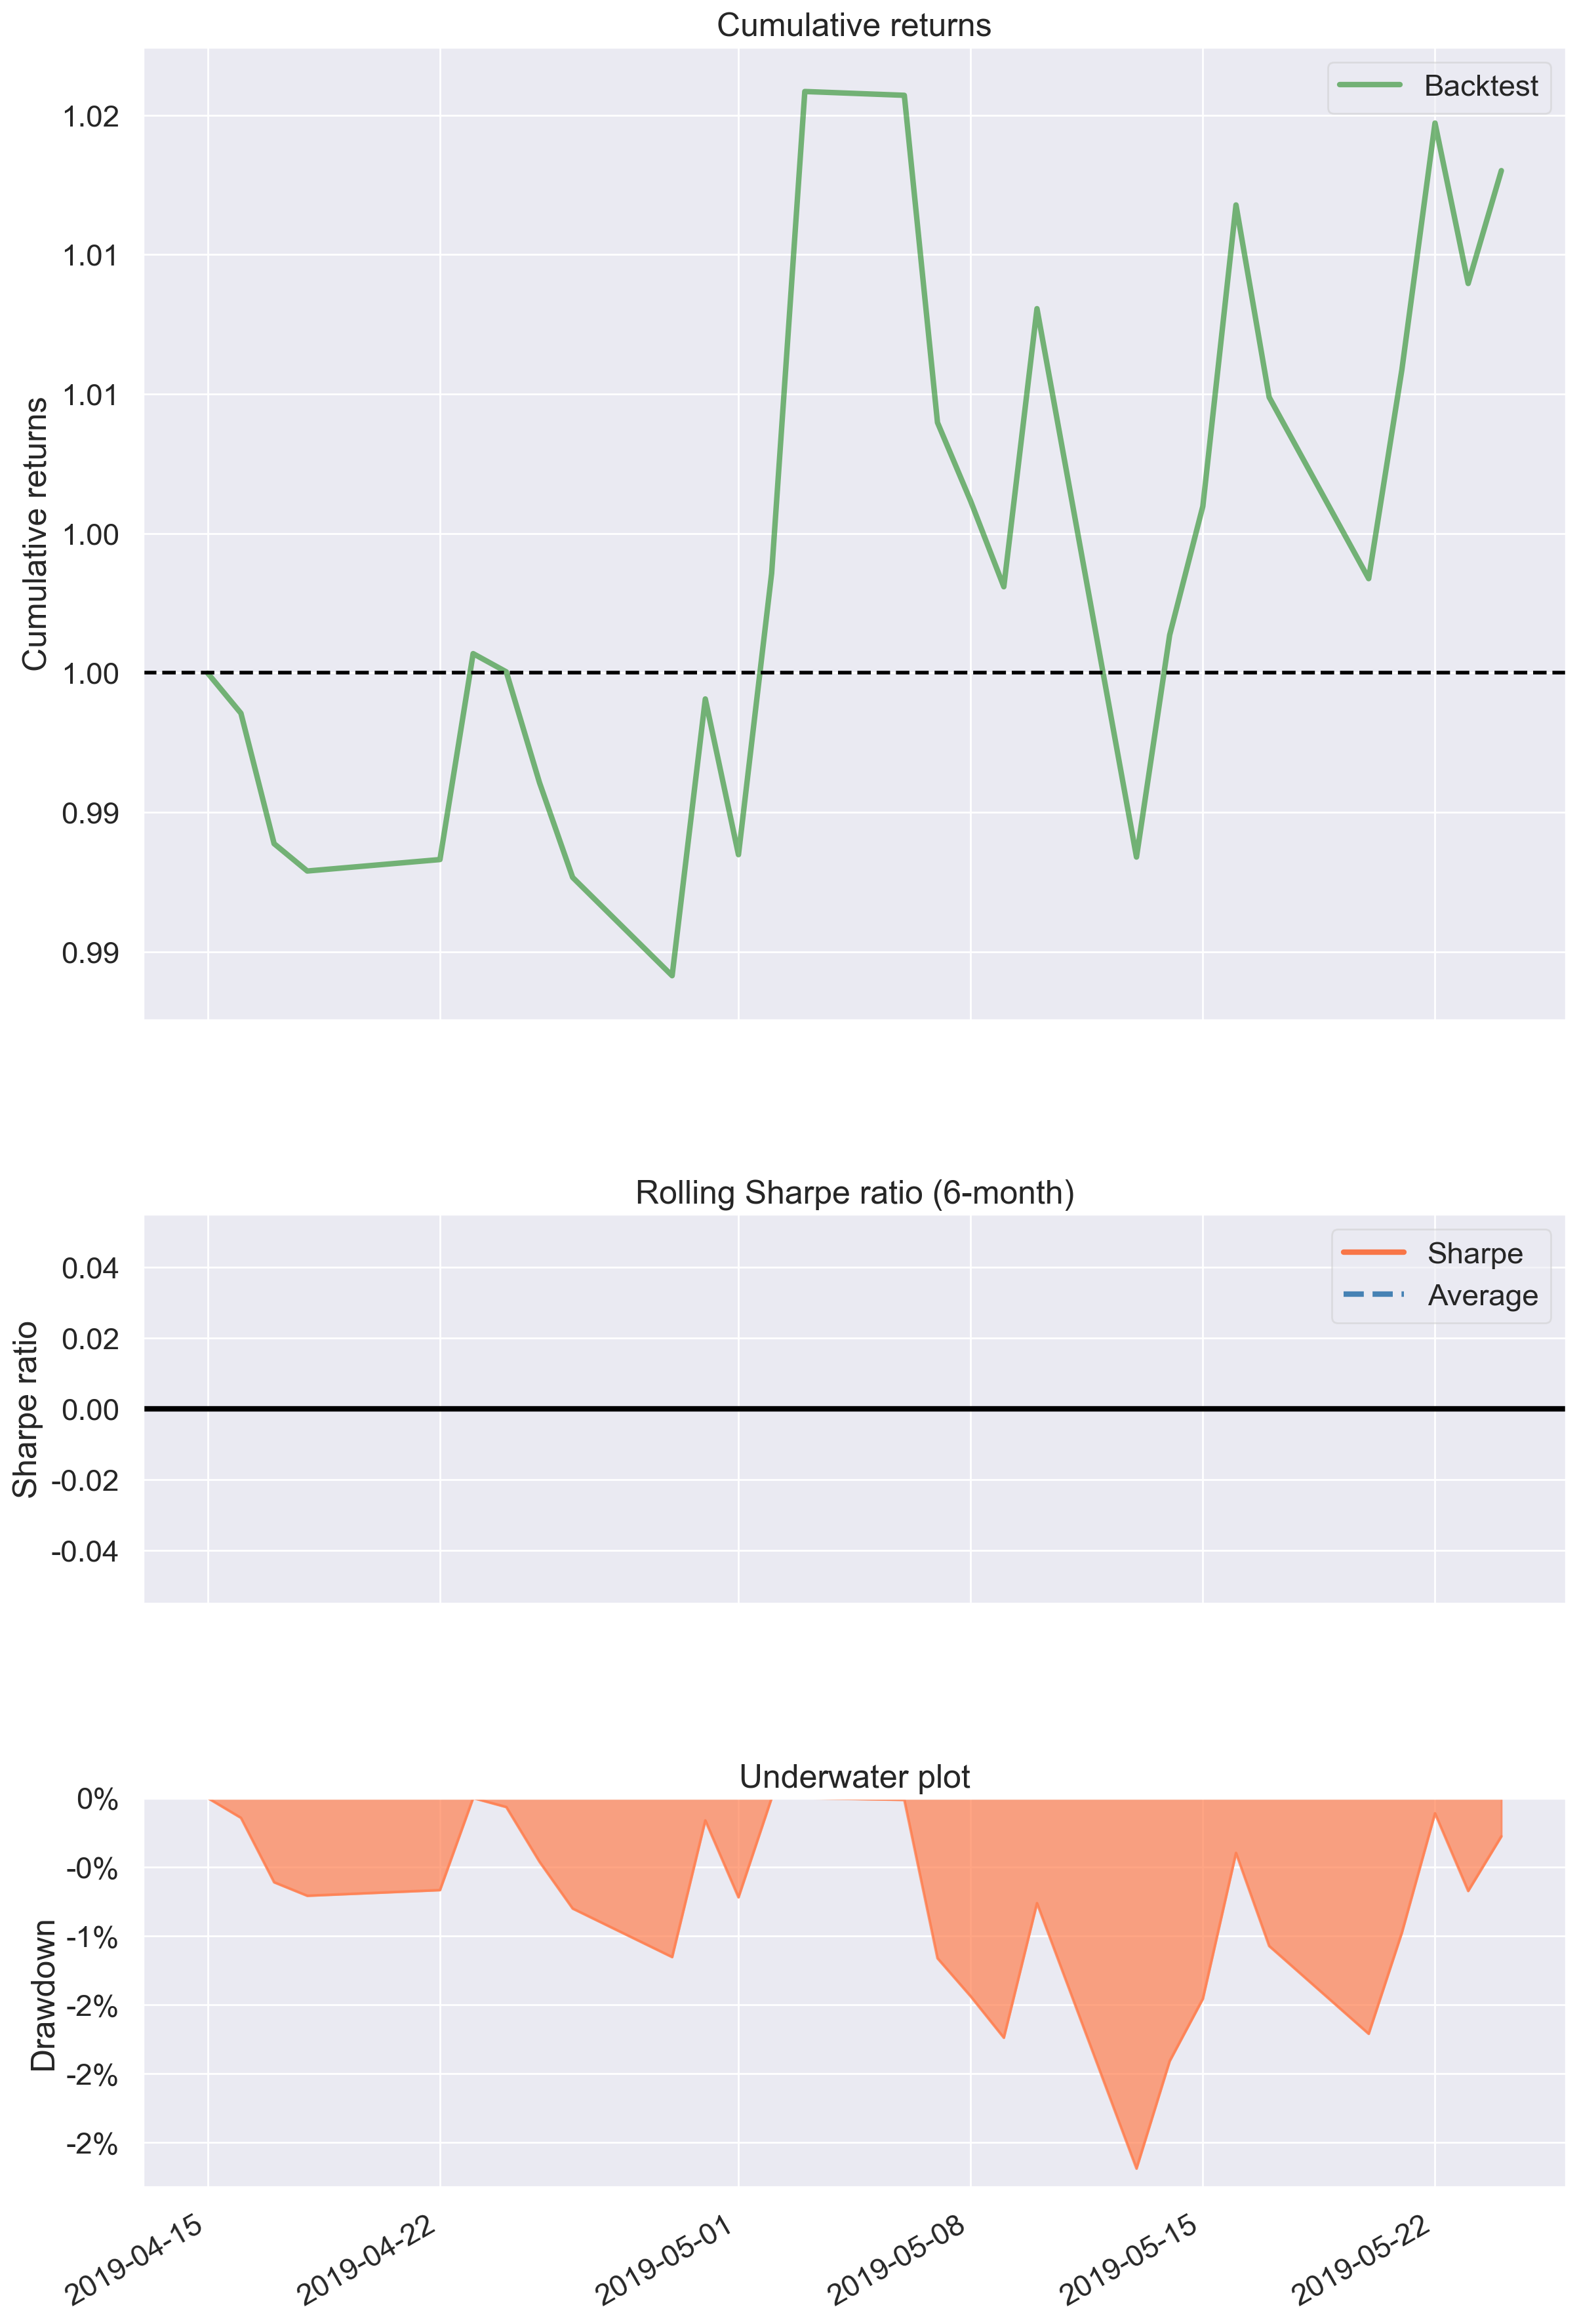

In [55]:
portfolio_weights = []
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_svr_df.sharpe_ratio)]):
    portfolio_weights.append(y)
returns = prices_df['Adj Close'].pct_change().dropna()
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T), index=returns.index)
pf.create_simple_tear_sheet(portfolio_returns)
#pf.create_returns_tear_sheet(portfolio_returns)

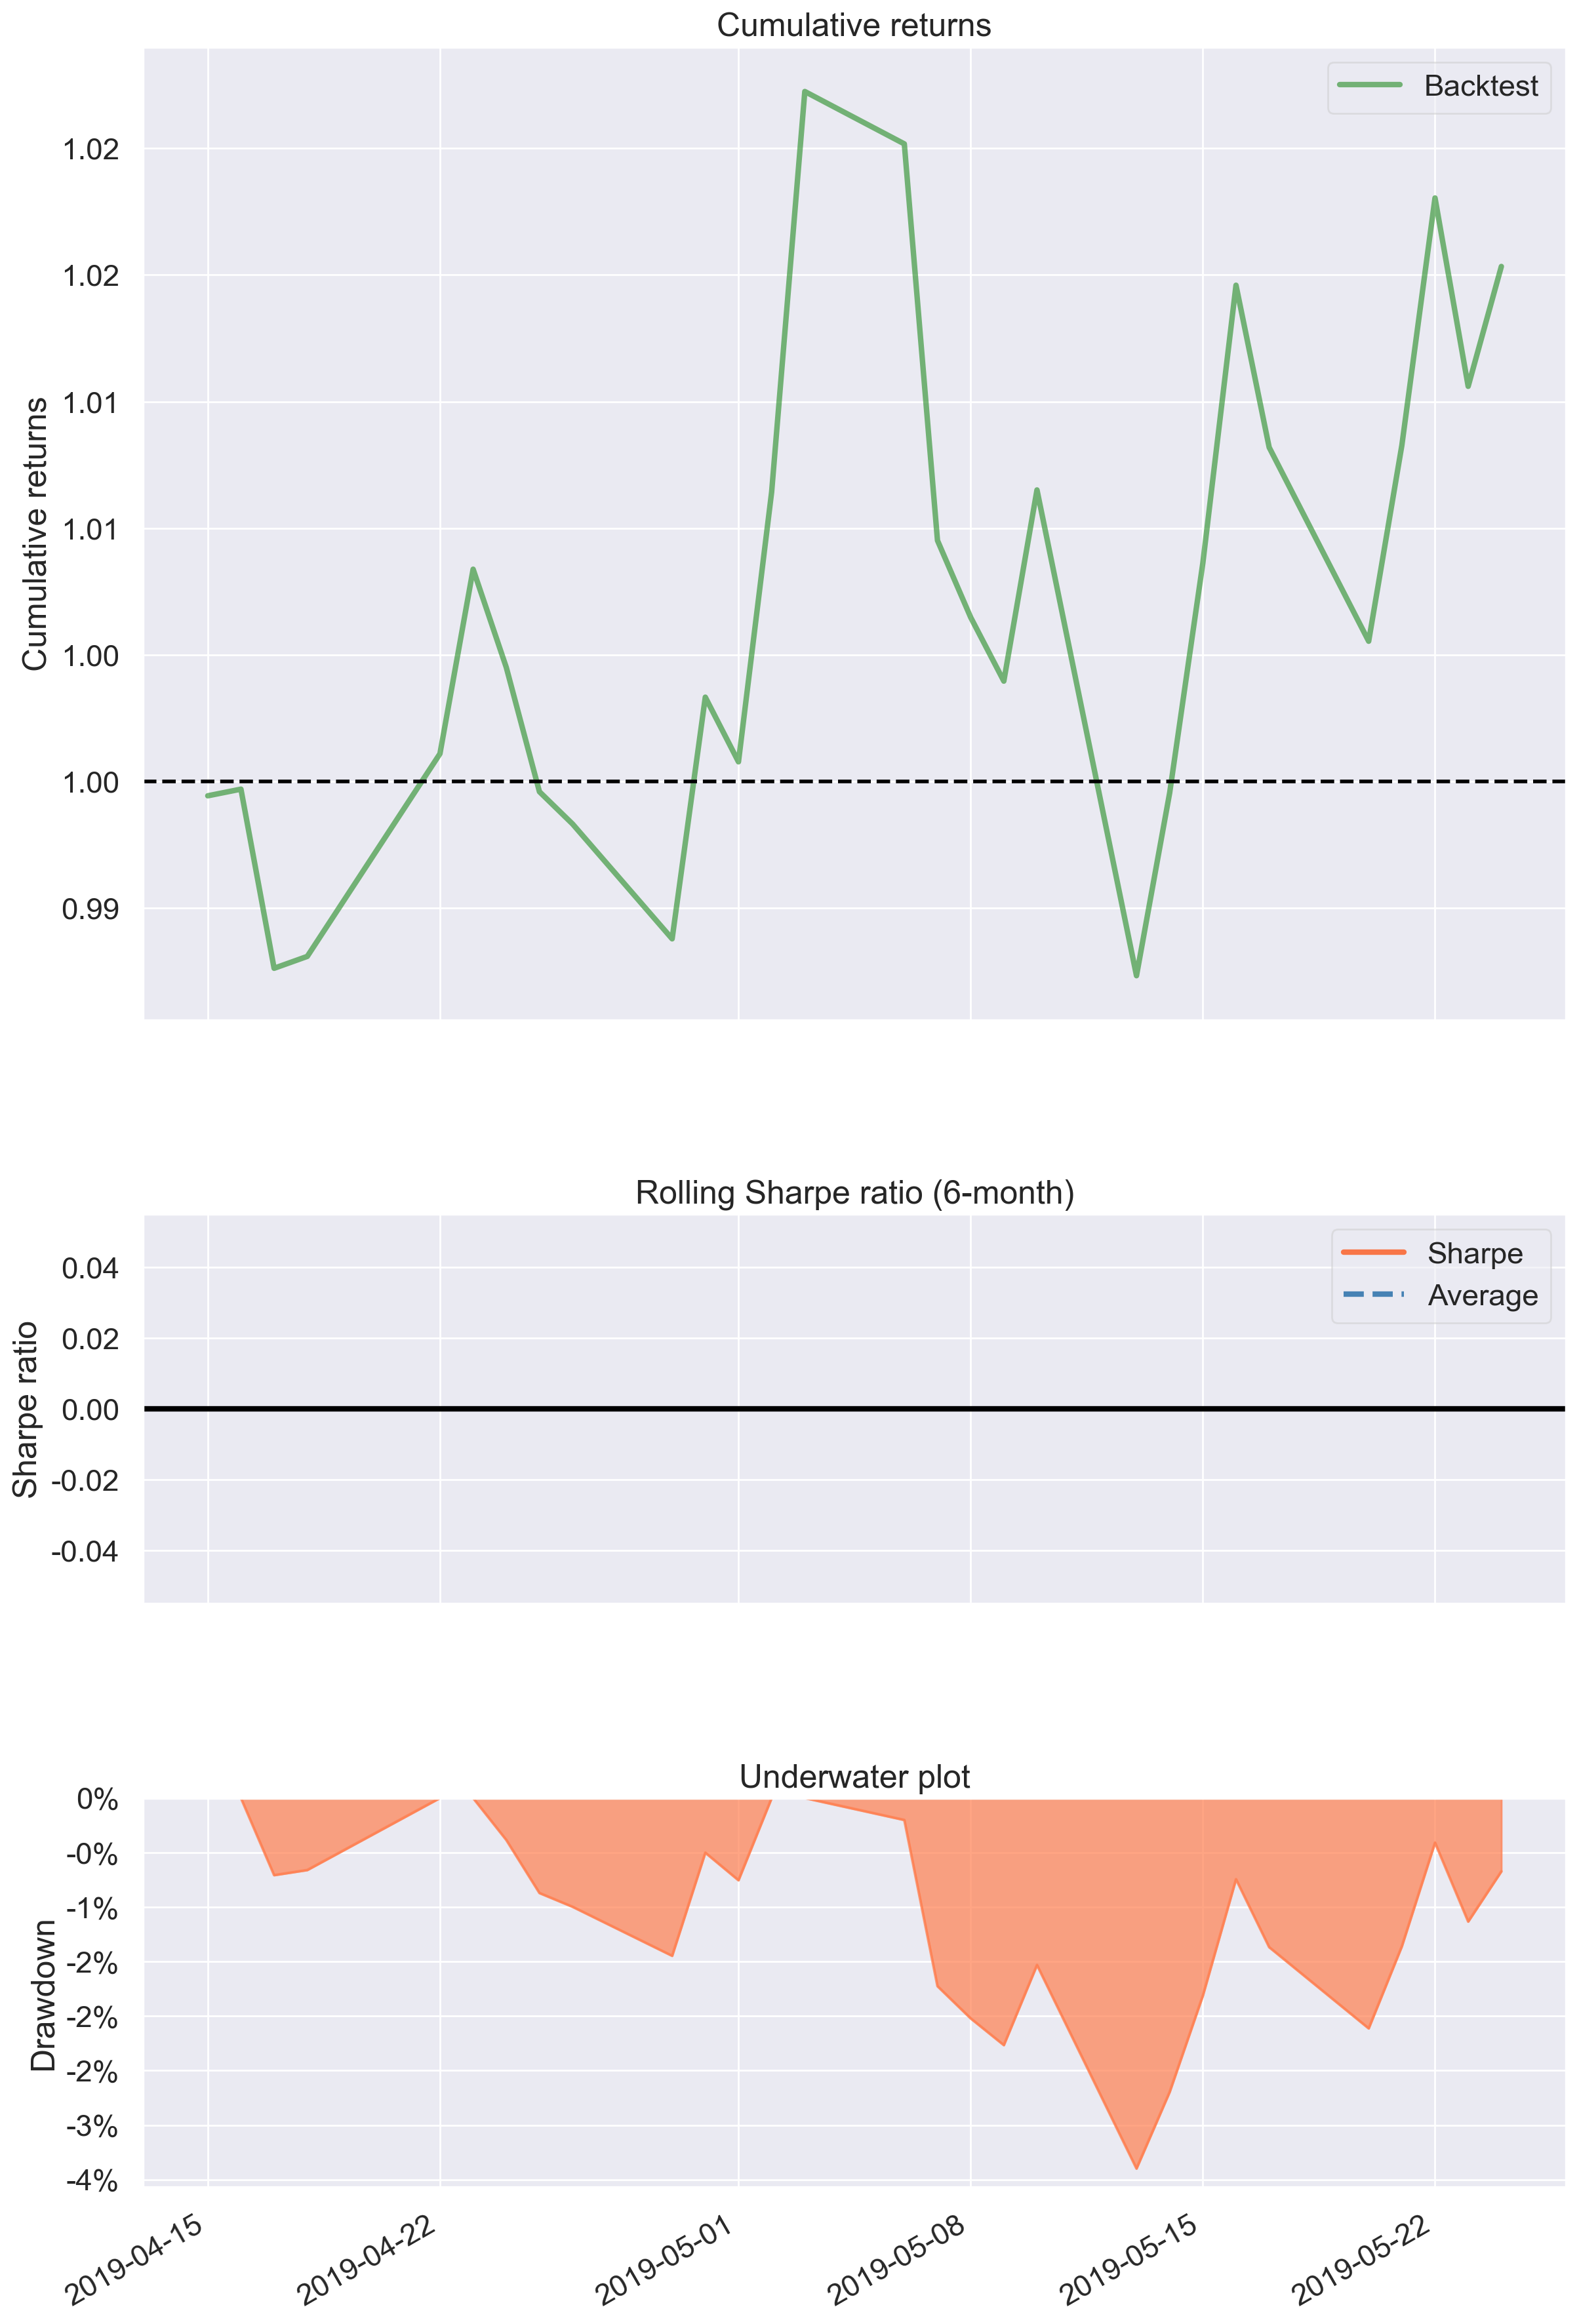

In [56]:
portfolio_weights = []
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_lstm_df.sharpe_ratio)]):
    portfolio_weights.append(y)
returns = prices_df['Adj Close'].pct_change().dropna()
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T), index=returns.index)
pf.create_simple_tear_sheet(portfolio_returns)
#pf.create_returns_tear_sheet(portfolio_returns)